In [1]:
import random
import numpy as np
from copy import copy, deepcopy
from tqdm import tqdm
from itertools import permutations
from itertools import takewhile
    

In [2]:
def read_instance(filename):

    with open(filename, 'r') as f:
        lines = f.readlines()

    first_line = lines[0].split()
    n = int(first_line[0])
    m = int(first_line[1])

    processing_times = [[0]*m for _ in range(n)]
    for i in range(n):
        line = lines[i+1].split()
        for j in range(m):
            processing_times[i][j] = int(line[j])
    
    last_line = lines[-1].split()
    ub = int(last_line[0])
    lb = int(last_line[1])

    return n, m, processing_times, ub, lb


In [8]:
class Individual_p:
    def __init__(self, processing_times, n, m):
        permutation = [i for i in range(n*m)]
        self.code = [-1 for i in range(n*m)]
        for i in range(n*m):
            self.code[i] = random.choice(permutation)
            permutation.remove(self.code[i])

        self.fitness = self.calc_fitness(processing_times,n,m)

    def check_job(self, start, limit, duration, job_activity):
        if len(job_activity) == 0:
            if start+duration<=limit:
                return (True, start) 
        elif len(job_activity) == 1:
            if job_activity[0][0] !=0 and job_activity[0][0]>=start+duration:
                return (True, start) 
            else:
                if job_activity[0][1] + duration <= limit:
                    return (True, max(job_activity[0][1],start)) 
        else:
            end = start + duration
            j=0
            while end <= limit and j<len(job_activity)-1:
                if job_activity[j][0] <= start < job_activity[j][1]:
                    start = job_activity[j][1]
                    end = start + duration
                    
                if start >= job_activity[j][1] and end <= job_activity[j+1][0]:        
                    return (True, start)
             
                j+=1
            
        return (False, -1)

    def calc_fitness(self, processing_times, n, m):
        jobs = [[] for _ in range(n)]
        machines = [[] for _ in range(m)]
        for operation in self.code:
                machine = operation % n
                job = operation // n
                duration = processing_times[job][machine]
                machine_activity = machines[machine]
                job_activity = jobs[job]
                
                fit, start, limit = False, -1, float('inf')
                if len(machine_activity) == 0:
                    start=0
                    fit, start = self.check_job(start, limit, duration, job_activity)
                elif len(machine_activity) == 1 and machine_activity[0][0] !=0:
                    start = 0
                    limit = machine_activity[0][0]
                    fit, start = self.check_job(start, limit, duration, job_activity)
                elif len(machine_activity) == 1 and machine_activity[0][0] == 0:
                    start = machine_activity[0][1]
                    fit, start = self.check_job(start, limit, duration, job_activity)
                else:
                    for i in range(len(machine_activity) - 1):
                        start = machine_activity[i][1]
                        limit = machine_activity[i+1][0]
                        options=[]
                        if limit-start>=duration:
                            fit, start = self.check_job(start, limit, duration, job_activity)
                            if fit:
                                options.append((start, limit-(start+duration)))
                    if len(options)>0:
                        options.sort(key=lambda x: x[1])
                        start = options[0][0]
                        fit = True
                            
                if fit and start+duration<=limit:
                    jobs[job].append((start, start+duration))
                    machines[machine].append((start, start+duration))
                    jobs[job].sort()
                    machines[machine].sort()
                else:
                    start=0
                    if len(machine_activity)>=1:
                        start = machine_activity[-1][1]
                    if len(job_activity)>=1:
                        start = max(start, job_activity[-1][1])
                    jobs[job].append((start, start+duration))
                    machines[machine].append((start, start+duration))
        
        
        for machine in machines:
            machine.sort(key=lambda x: x[1], reverse=True)
        return max([machine[0][1] for machine in machines])

In [9]:
class Individual_h:
    def __init__(self, processing_times, n, m):
        self.code = [random.randrange(0,n) for _ in range(n*m)]
        self.fitness = self.calc_fitness(processing_times, n, m)
        
    def check_job(self, start, limit, duration, job_activity):
        if len(job_activity) == 0:
            if start+duration<=limit:
                return (True, start) 
        elif len(job_activity) == 1:
            if job_activity[0][0] !=0 and job_activity[0][0]>=start+duration:
                return (True, start) 
            elif job_activity[0][0] == 0:
                if job_activity[0][1] + duration <= limit:
                    return (True, max(job_activity[0][1],start)) 
        else:
            end = start + duration
            j=0
            while end <= limit and j<len(job_activity)-1:
                if job_activity[j][0] <= start < job_activity[j][1]:
                    start = job_activity[j][1]
                    end = start + duration
    
                if start >= job_activity[j][1] and end <= job_activity[j+1][0]:        
                    return (True, start)
             
                j+=1
            
        return (False, -1)

# machines = [[(0,14), (16, 20)], [(0,16), (16,31)]], [(20,50)]
# jobs = [[(0,16), (16,20)], [(0,14),(16,31)]]

    def calc_fitness(self, processing_times, n, m):
        jobs = [[] for _ in range(n)]
        machines = [[] for _ in range(m)]
        untackled_operations = [[(j,processing_times[i][j]) for j in range(m)] for i in range(n)]
        for i in range(n):
            untackled_operations[i].sort(key = lambda op: op[1], reverse=True)

        for i in range(len(self.code)):
                job=self.code[i]
                while len(untackled_operations[job]) == 0:
                    job = (job+1) % n
                    
                empty_slots=[]
                for machine, machine_activity in enumerate(machines):
                    for i in range(len(machine_activity) - 1):
                        if i==0 and machine_activity[0][0]!=0:
                            duration = machine_activity[0][0]
                            empty_slots.append((machine, duration))
                        
                        duration = machine_activity[i+1][0] - machine_activity[i][1]
                        empty_slots.append((machine, duration))
                        
                options = []
                for operation in untackled_operations[job]:
                    for slot in empty_slots:
                        if operation[0]==slot[0] and operation[1]<=slot[1]:
                            options.append(operation)
                            break
                            
                if len(options)>0:
                    for option in options:
                        next_operation = option
                    
                        machine, duration = next_operation
                        machine_activity = machines[machine]
                        job_activity = jobs[job]
                
                
                        fit, start, limit = False, -1, float('inf')
                        if len(machine_activity) == 0:
                            start=0
                            fit, start = self.check_job(start, limit, duration, job_activity)
                        elif len(machine_activity) == 1 and machine_activity[0][0] !=0:
                            start = 0
                            limit = machine_activity[0][0]
                            fit, start = self.check_job(start, limit, duration, job_activity)
                        elif len(machine_activity) == 1 and machine_activity[0][0] == 0:
                            start = machine_activity[0][1]
                            fit, start = self.check_job(start, limit, duration, job_activity)
                        else:
                            for i in range(len(machine_activity) - 1):
                                start = machine_activity[i][1]
                                limit = machine_activity[i+1][0]
                                if limit-start>=duration:
                                    fit, start = self.check_job(start, limit, duration, job_activity)
                            
                        if fit and start+duration<=limit:
                            jobs[job].append((start, start+duration))
                            machines[machine].append((start, start+duration))
                            jobs[job].sort()
                            machines[machine].sort()
                            break
                           
                else:
                    next_operation = untackled_operations[job][0]
                    
                    machine, duration = next_operation
                    machine_activity = machines[machine]
                    job_activity = jobs[job]
                    start=0
                    if len(machine_activity)>=1:
                        start = machine_activity[-1][1]
                    if len(job_activity)>=1:
                        start = max(start, job_activity[-1][1])
                    jobs[job].append((start, start+duration))
                    machines[machine].append((start, start+duration))
                    
                untackled_operations[job].remove(next_operation)

        for machine in machines:
            machine.sort(key=lambda x: x[1], reverse=True)
        return max([machine[0][1] for machine in machines])

In [10]:
# generational genetic algorithm
# uniform crossover with rate 0.6,
# swap mutation with rate 0.1
# roulette wheel selection (size of the slot on the roulette is inversly proportional to the fitness value (makespan) of each chromosome)
# 500 generations with 200 chromosomes


def selection_p(population):
    population_fitness = sum([1/chromosome.fitness for chromosome in population])
    
    chromosome_probabilities = [(1/(chromosome.fitness)/population_fitness) for chromosome in population]
    
    parents = random.choices(population, weights=chromosome_probabilities, k=2)
   
    return (parents[0], parents[1])

def selection_h(population):
    population_fitness = sum([1/chromosome.fitness for chromosome in population])
    
    chromosome_probabilities = [(1/(chromosome.fitness)/population_fitness) for chromosome in population]
    
    parents = random.choices(population, weights=chromosome_probabilities, k=2)
   
    return (parents[0], parents[1])

def crossover_h (parent1, parent2, child1, child2):
    for i in range(len(parent1.code)):
        if random.random() < 0.5:
            child1.code[i] = parent1.code[i]
            child2.code[i] = parent2.code[i]
        else:
            child1.code[i] = parent2.code[i]
            child2.code[i] = parent1.code[i]
            
def crossover_p (parent1, parent2, child1, child2):
    code1 = [-1]*len(child1.code)
    code2 = [-1]*len(child1.code)
    p1 = parent1.code.copy()
    p2 = parent2.code.copy()
    for i in range(len(parent1.code)):
        if random.random()<0.5:
            code1[i]=parent1.code[i]
            p2.remove(parent1.code[i])
            code2[i]=parent2.code[i]
            p1.remove(parent2.code[i])
    j=0
    for i in range(len(code1)):
        if code1[i]==-1:
            code1[i]=p2[j]
            code2[i]=p1[j]
            j+=1

    child1.code = code1.copy()
    child2.code = code2.copy()
    
def mutation (child, rate):
    i = random.randrange(0,len(child.code))
    j=i
    while j==i:
        j = random.randrange(0,len(child.code))
    child.code[i], child.code[j] = child.code[j], child.code[i]

def ga_permutation(pop_size, num_iters, crossover_rate, mutation_rate, elitism_size, n, m, processing_times):
    
    if (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    population = [Individual_p(processing_times, n, m) for _ in range(pop_size)]
    new_population =[ Individual_p(processing_times, n, m) for _ in range(pop_size)]
    
    for _ in range(num_iters):
            
        population.sort(key=lambda x: x.fitness)  
        new_population[:elitism_size] = population[:elitism_size]
        
        for i in range(elitism_size, pop_size, 2):
            parent1, parent2 = selection_p(population)
            
            if random.random() < crossover_rate:
                crossover_p(parent1, parent2,
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_rate)
            mutation(new_population[i+1], mutation_rate)
            
            new_population[i].fitness = new_population[i].calc_fitness(processing_times, n, m)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(processing_times, n, m)
        
        population = deepcopy(new_population)
            
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness
    
def ga_hybrid(pop_size, num_iters, crossover_rate, mutation_rate, elitism_size, n, m, processing_times):
    
    if (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    population = [Individual_h(processing_times, n, m) for _ in range(pop_size)]
    new_population = [Individual_h(processing_times, n, m) for _ in range(pop_size)]
    
    for it in (range(num_iters)):
        
        population.sort(key=lambda x: x.fitness)  
        new_population[:elitism_size] = population[:elitism_size]
        
        for i in range(elitism_size, pop_size, 2):
            parent1, parent2 = selection_h(population)

            if random.random() < crossover_rate:
                crossover_h(parent1, parent2,
                      new_population[i],
                      new_population[i+1])
            
            if random.random() < mutation_rate:
                mutation(new_population[i], mutation_rate)
                mutation(new_population[i+1], mutation_rate)

            new_population[i].fitness = new_population[i].calc_fitness(processing_times, n, m)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(processing_times, n, m)
        
        population = deepcopy(new_population)
            
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.fitness


In [ ]:
pop_size =  200
num_iters =  500
crossover_rate = 0.6
mutation_rate = 0.1
elitism_size = int(0.2*pop_size)
bounds = [(0,0) for _ in range(10)]

results = [[] for _ in range(10)]
for i in range(10):
    instance_file = "tests/test55" + str(i)
    n, m, processing_times, ub, lb = read_instance(instance_file)
    bounds[i] = (lb, ub)
    j=0
    for it in tqdm(range(20)):
        results[i].append(ga_permutation(pop_size, num_iters, crossover_rate, mutation_rate, elitism_size, n, m, processing_times))
        j+=1
    print(min(results[i]))
    

 25%|███████████                                 | 5/20 [01:11<03:49, 15.32s/it]

In [ ]:
print('upper_bounds: ')
print([bounds[i][0] for i in range(10)])
print('lower bounds: ')
print([bounds[i][1] for i in range(10)])

best = [min([results[i][j][1] for j in range(len(results[i]))]) for i in range(6)]
mean = [int(sum([results[i][j][1] for j in range(len(results[i]))])/(len(results[i]))) for i in range(6)]
print('best: ')
print(best)
print('mean')
print(mean)

In [ ]:
processing_times= [[[52,13,77], [11,20,42], [7, 44, 32]], 
                   [[40, 5,18], [30,21,14], [8, 37, 16]],
                   [[15,31,72], [19,30,62], [22, 54, 12]],
                   [[19,30,62], [52,13,77], [19, 34, 28]],
                   [[27,32,51], [11,40,20], [71, 40, 60]],
                   [[20,37,77], [61,10,42], [70, 15, 43]],
                   [[12,51,17], [41,20,12], [16, 50, 29]],
                   [[50,10,70], [10,20,40], [70, 40, 30]],
                   [[29,16,67], [43,50,17], [63, 4, 72]],
                   [[34,25,69], [17,80,22], [81, 14, 32]]
    
]
pop_size =  200
num_iters =  500
crossover_rate = 0.6
mutation_rate = 0.1
elitism_size = int(0.2*pop_size)
results=[]
for times in processing_times:
    results.append(ga_hybrid(pop_size, num_iters, crossover_rate, mutation_rate, elitism_size, 3, 3, times))
print(results)
# permutation vraca iste rez kao brute force

In [7]:
print([res for res in results])

[[], [], [], [], [], [], [], [], [], []]


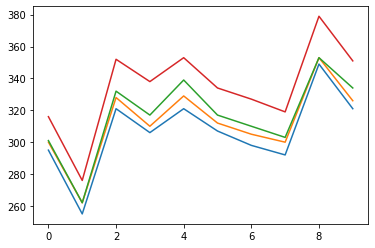

In [94]:
from matplotlib import pyplot as plt
plt.plot(range(10), [bounds[i][0] for i in range(10)])
plt.plot(range(10), [bounds[i][1] for i in range(10)])
plt.plot(range(10), best)
plt.show()
